In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22158 entries, 0 to 22157
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22158 non-null  object 
 1   description               22158 non-null  object 
 2   summary                   22157 non-null  object 
 3   installs                  22158 non-null  object 
 4   minInstalls               22158 non-null  float64
 5   score                     22158 non-null  float64
 6   ratings                   22158 non-null  float64
 7   reviews                   22158 non-null  float64
 8   histogram                 22158 non-null  object 
 9   price                     22158 non-null  float64
 10  free                      22158 non-null  int64  
 11  currency                  22158 non-null  object 
 12  sale                      22158 non-null  bool   
 13  offersIAP                 22158 non-null  bool   
 14  inAppP

In [5]:
df_sentiment = pd.read_csv('merged_sentiment.csv')

In [6]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='title',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [7]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

y = df['score']

In [8]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [9]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','year','top_developer',
        'installs_day','updated_days','has_video','compound']]

In [10]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [11]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [12]:
# Further split temporary tr to create train and val
#X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

In [19]:
X_train

,ratings,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,compound,...,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen
2055,17614.0,1,1,0,2015,1,527.704485,133,0,0.407135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5222,22825.0,1,1,0,2018,0,909.918107,497,0,-0.119817,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7919,10367.0,1,1,0,2020,0,2392.344498,161,0,0.167699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7647,7224.0,1,1,0,2017,0,844.594595,1,1,0.289224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16907,12895.0,1,0,0,2015,0,463.177397,1,0,0.290431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21268,1313.0,1,1,0,2016,0,564.971751,164,0,0.439643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9788,11460.0,1,0,0,2013,0,370.096225,20,1,0.006099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21370,5529.0,1,1,0,2018,0,885.739593,218,0,0.380771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20001,3388.0,1,1,0,2013,0,342.583076,198,0,0.230925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


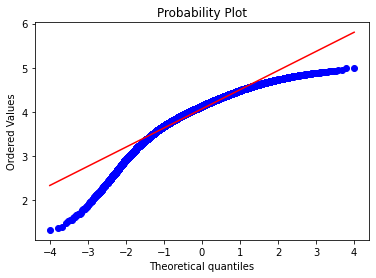

In [13]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22158
- Mean of distribution of rating : 4.068657300252703
- Standard deviation: 0.449417053871379


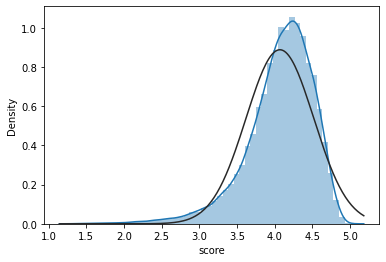

In [14]:
sns.distplot(df['score'],fit=stats.norm)
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))

In [37]:
def split_and_validate(X, feature,y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(combo_train_df, y_tr, test_size=0.2, random_state=10)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train[feature], y_train)
    
    # Find predictions
    y_pred = lr_model.predict(X_val[feature])
    
    # score fit model on validation data
    val_score = lr_model.score(X_val[feature], y_val)
    val_MSE = mean_squared_error(y_val, y_pred)
    val_MAE = mean_absolute_error(y_val, y_pred)
    
    # report results
    print('\nValidation R^2 score was: {:.2f}'.format(val_score))
    print('MSE of linear regression on val set: {:.2f}'.format(val_MSE))
    print('MAE of linear regression on val set: {:.2f}'.format(val_MAE))
    print('Feature coefficient results: \n')
    for feature, coef in zip(X_train[feature].columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

## All features

In [50]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'compound', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [39]:
split_and_validate(X_train,features,y_train)


Validation R^2 score was: 0.42
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.26
Feature coefficient results: 

ratings : 0.00
free : 0.13
containsAds : 0.01
editorsChoice : 0.06
year : -0.01
top_developer : 0.37
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
compound : 1.16
genre_Adventure : -0.12
genre_Arcade : -0.00
genre_Art & Design : -0.05
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.16
genre_Board : 0.10
genre_Books & Reference : 0.10
genre_Business : 0.14
genre_Card : 0.17
genre_Casino : 0.16
genre_Casual : -0.04
genre_Comics : -0.06
genre_Communication : 0.02
genre_Dating : -0.02
genre_Education : 0.02
genre_Entertainment : -0.07
genre_Events : -0.01
genre_Finance : 0.09
genre_Food & Drink : 0.18
genre_Health & Fitness : 0.11
genre_House & Home : 0.07
genre_Libraries & Demo : -0.03
genre_Lifestyle : -0.00
genre_Maps & Navigation : 0.12
genre_Medical : -0.05
genre_Music : -0.07
genre_Music & Audio : 0.05
genre_News & Magazines : 0

## Removing ratings, installs / day, days since last update, year, mature audiences, lifestyle, sports, medical, weather, dating etc

In [76]:
features2 = features.copy()
features2.remove('ratings')
features2.remove('installs_day')
features2.remove('updated_days')
features2.remove('containsAds')
features2.remove('year')
features2.remove('contentRating_Mature 17+')
features2.remove('contentRating_Teen')
features2.remove('genre_Lifestyle')
features2.remove('genre_Sports')
features2.remove('genre_Arcade')
features2.remove('genre_Medical')
features2.remove('genre_Weather')
features2.remove('genre_Dating')
features2.remove('genre_Libraries & Demo')
features2.remove('genre_Education')

In [77]:
split_and_validate(X_train,features2,y_train)


Validation R^2 score was: 0.37
MSE of linear regression on val set: 0.12
MAE of linear regression on val set: 0.27
Feature coefficient results: 

free : -0.12
editorsChoice : 0.15
top_developer : 0.47
has_video : 0.07
compound : 1.15
genre_Adventure : -0.13
genre_Art & Design : -0.07
genre_Auto & Vehicles : 0.09
genre_Beauty : -0.15
genre_Board : 0.12
genre_Books & Reference : 0.12
genre_Business : 0.17
genre_Card : 0.21
genre_Casino : 0.22
genre_Casual : -0.03
genre_Comics : -0.09
genre_Communication : 0.03
genre_Entertainment : -0.07
genre_Events : -0.05
genre_Finance : 0.16
genre_Food & Drink : 0.21
genre_Health & Fitness : 0.13
genre_House & Home : 0.10
genre_Maps & Navigation : 0.14
genre_Music : -0.04
genre_Music & Audio : 0.05
genre_News & Magazines : 0.05
genre_Parenting : 0.07
genre_Personalization : 0.07
genre_Photography : -0.07
genre_Productivity : 0.09
genre_Puzzle : 0.13
genre_Racing : -0.04
genre_Role Playing : -0.04
genre_Shopping : 0.19
genre_Simulation : -0.11
genre_

### Test

In [42]:
X_test_cont = X_test[['free','containsAds','editorsChoice','year','top_developer','has_video','compound', 'updated_days']]

In [43]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [44]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [196]:
y_pred_test = lr11.predict(combo_test_df[features11])
print('R^2 of linear regression on val set: {:.2f}'.format(lr11.score(combo_test_df[features11], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.35
MSE of linear regression on val set: 0.36
MAE of linear regression on val set: 0.52
